# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from datetime import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from scipy.spatial.transform import Rotation as R
from sklearn.linear_model import LinearRegression

from utils import *
from grace.utils import *

# Initialization

## Helper Functions

In [2]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#7fff00', '#d2b48c', '#000080']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    if ret:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners = cv2.cornerSubPix(gray, corners, (9,9), (-1,-1), criteria)
        corners = corners.squeeze()
    else:
        corners = None
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    if corners is not None:
        int_corners = np.round(corners).astype(int)

        depth_list = []
        for corner in int_corners:
            depth_list.append(depth_img[corner[1], corner[0]])
        depth_list = np.array(depth_list)
        depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0

        fx = camera_mtx[0][0]
        cx = camera_mtx[0][2]
        fy = camera_mtx[1][1]
        cy = camera_mtx[1][2]

        obj_pts = []
        for i,(u,v) in enumerate(corners):
            z = depth_list[i]/1000.0
            if z<=0:
                z = depth_mean
            z = z - 0.0042  # Added realsense discrepancy
            x = ((u-cx)/fx)*z
            y = ((v-cy)/fy)*z
            obj_pts.append([x, y, z])
        obj_pts = np.array(obj_pts)
    else:
        obj_pts = None
        
    return obj_pts

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    if corners is not None:
        # Estimate the extrinsic matrix
        # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
        retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
        # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)

        # Convert the rotation vector to a rotation matrix
        rotation_matrix, _ = cv2.Rodrigues(rvec)

        # Homogeneous Coordinates
        H = np.eye(4)
        H[:3,:3] = rotation_matrix
        H[:3,-1] = tvec.T

        # Camera Pose
        T = np.linalg.inv(H)
    else:
        T = None
    
    return T

def get_rmse_pose(T, img, obj_pts, camera_mtx, dist_coef):
    if T is not None:
        T = np.linalg.inv(T)  # Input T is T_board_to_any
        corners = get_chess_corners(img, camera_mtx, dist_coef)

        rvec,_ = cv2.Rodrigues(T[:3,:3])
        tvec = T[:3,-1].reshape(-1,1)

        # Project the 3D points onto the image plane
        projected_points, _ = cv2.projectPoints(obj_pts, rvec, tvec, camera_mtx, dist_coef)

        # Calculate the RMSE
        error = np.sqrt(np.mean(np.square(corners - projected_points.squeeze())))
    else:
        error = 1000
    return error
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    z = z - 0.0042  # Added realsense discrepancy
    if z<=0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

def transform_points(pts, T_mtx):
    new_obj_pts = []
    for pt in pts:
        temp_pt = np.append(pt, 1).reshape(-1,1)
        temp_pt2 = (T_mtx @ temp_pt).squeeze()
        new_obj_pts.append(temp_pt2[:3])
    new_obj_pts = np.array(new_obj_pts)
    return new_obj_pts

def chest_rgb_to_eye(T_chest, T_input):
    T_chest_inv = np.linalg.inv(T_chest)  # T_cb = T_bc^(-1)
    T_final = np.matmul(T_chest_inv, T_input)  # T_cl = T_cb x T_bl
    return T_final

# Loading of Data

## Pickle Data

In [3]:
filename = 'head_panuppertilt_baseline_sweep_pickle_20240423_012227_738009.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'head_panuppertilt_baseline_sweep',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

## Preprocessing



In [6]:
# Assigning next step data for tminus1

pickle_df['theta_left_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_left_pan_cmd'][:-2].tolist() 
pickle_df['theta_right_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_right_pan_cmd'][:-2].tolist() 
pickle_df['theta_tilt_cmd_tminus2'] = [0,0] + pickle_df['theta_tilt_cmd'][:-2].tolist()
pickle_df['theta_left_pan_cmd_tminus1'] = [0] + pickle_df['theta_left_pan_cmd'][:-1].tolist() 
pickle_df['theta_right_pan_cmd_tminus1'] = [0] + pickle_df['theta_right_pan_cmd'][:-1].tolist() 
pickle_df['theta_tilt_cmd_tminus1'] = [0] + pickle_df['theta_tilt_cmd'][:-1].tolist()

pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()

pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

pickle_df['theta_neck_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_neck_pan_cmd'][:-2].tolist() 
pickle_df['theta_upper_tilt_left_cmd_tminus2'] = [0,0] + pickle_df['theta_upper_tilt_left_cmd'][:-2].tolist() 
pickle_df['theta_upper_tilt_right_cmd'] = [0,0] + pickle_df['theta_upper_tilt_right_cmd'][:-2].tolist()
pickle_df['theta_neck_pan_cmd_tminus1'] = [0] + pickle_df['theta_neck_pan_cmd'][:-1].tolist() 
pickle_df['theta_upper_tilt_left_cmd_tminus1'] = [0] + pickle_df['theta_upper_tilt_left_cmd'][:-1].tolist() 
pickle_df['theta_upper_tilt_right_cmd_tminus1'] = [0] + pickle_df['theta_upper_tilt_right_cmd'][:-1].tolist()

In [7]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [8]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_pan_angle', 'chest_tilt_angle', 'plan_phi_left_pan',
       'plan_phi_right_pan', 'plan_phi_tilt', 'chest_img', 'left_eye_img',
       'right_eye_img', 'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'theta_left_pan_cmd',
       'theta_right_pan_cmd', 'theta_tilt_cmd', 'theta_neck_pan_cmd',
       'theta_upper_tilt_left', 'theta_upper_tilt_right',
       'theta_upper_tilt_left_cmd', 'theta_upper_tilt_right_cmd',
       'theta_left_pan_cmd_tminus2', 'theta_right_pan_cmd_tminus2',
       'theta_tilt_cmd_tminus2', 'the

In [9]:
# Dropping the first row
pickle_df = pickle_df.drop(np.arange(0,2)).reset_index(drop=True)
pickle_df.head()

chess_idx theta_left_pan theta_right_pan theta_tilt   
0          4           None            None       None  \
1          6           None            None       None   
2          8           None            None       None   
3          6           None            None       None   
4          4           None            None       None   

   chest_cam_px_x_tminus1  chest_cam_px_y_tminus1  left_eye_px_x_tminus1   
0              386.624451              155.395966             493.580688  \
1              423.175323              154.130157            -360.600000   
2              459.459869              153.038849             552.453674   
3              495.873291              152.051056            -360.600000   
4              459.465179              152.996948             530.551758   

   left_eye_px_y_tminus1  right_eye_px_x_tminus1  right_eye_px_y_tminus1  ...   
0             227.238266              315.146820              239.204834  ...  \
1            -224.700000             -222.300000             -235.900000  ...   
2             228.914917              366.586395              241.918472  ...   
3            -224.700000             -222.300000             -235.900000  ...   
4             229.196640              347.604401              241.752594  ...   

   plan_phi_right_pan_tminus1  plan_phi_tilt_tminus1   
0                         0.0                    0.0  \
1                         0.0                    0.0   
2                         0.0                    0.0   
3                         0.0                    0.0   
4                         0.0                    0.0   

   theta_neck_pan_cmd_tminus2  theta_upper_tilt_left_cmd_tminus2   
0                         -35                                 57  \
1                         -12                                  0   
2                         -35                                 57   
3                         -10                                  0   
4                         -35                                 57   

   theta_neck_pan_cmd_tminus1  theta_upper_tilt_left_cmd_tminus1   
0                         -12                                  0  \
1                         -35                                 57   
2                         -10                                  0   
3                         -35                                 57   
4                          -8                                  0   

   theta_upper_tilt_right_cmd_tminus1  phi_direction_left_pan   
0                                   0                       3  \
1                                 -57                       3   
2                                   0                       3   
3                                 -57                       3   
4                                   0                       3   

   phi_direction_right_pan  phi_direction_tilt  
0                        3                   3  
1                        3                   3  
2                        3                   3  
3                        3                   3  
4                        3                   3  

[5 rows x 66 columns]

# 1st Filtering: Remove Reset Command

In [10]:
filt_df = pickle_df[(pickle_df['theta_neck_pan_cmd_tminus1']>-16) & (pickle_df['theta_left_pan_cmd_tminus1']<16) ].reset_index(drop=True)
filt_df.head()

chess_idx theta_left_pan theta_right_pan theta_tilt   
0          4           None            None       None  \
1          8           None            None       None   
2          4           None            None       None   
3          0           None            None       None   
4          4           None            None       None   

   chest_cam_px_x_tminus1  chest_cam_px_y_tminus1  left_eye_px_x_tminus1   
0              386.624451              155.395966             493.580688  \
1              459.459869              153.038849             552.453674   
2              459.465179              152.996948             530.551758   
3              386.636475              155.412720             429.377716   
4              386.622284              155.423111             406.640930   

   left_eye_px_y_tminus1  right_eye_px_x_tminus1  right_eye_px_y_tminus1  ...   
0             227.238266              315.146820              239.204834  ...  \
1             228.914917              366.586395              241.918472  ...   
2             229.196640              347.604401              241.752594  ...   
3             228.090088              255.699310              238.524719  ...   
4             228.184830              233.475357              238.274261  ...   

   plan_phi_right_pan_tminus1  plan_phi_tilt_tminus1   
0                         0.0                    0.0  \
1                         0.0                    0.0   
2                         0.0                    0.0   
3                         0.0                    0.0   
4                         0.0                    0.0   

   theta_neck_pan_cmd_tminus2  theta_upper_tilt_left_cmd_tminus2   
0                         -35                                 57  \
1                         -35                                 57   
2                         -35                                 57   
3                         -35                                 57   
4                         -35                                 57   

   theta_neck_pan_cmd_tminus1  theta_upper_tilt_left_cmd_tminus1   
0                         -12                                  0  \
1                         -10                                  0   
2                          -8                                  0   
3                          -6                                  0   
4                          -4                                  0   

   theta_upper_tilt_right_cmd_tminus1  phi_direction_left_pan   
0                                   0                       3  \
1                                   0                       3   
2                                   0                       3   
3                                   0                       3   
4                                   0                       3   

   phi_direction_right_pan  phi_direction_tilt  
0                        3                   3  
1                        3                   3  
2                        3                   3  
3                        3                   3  
4                        3                   3  

[5 rows x 66 columns]

In [11]:
print(filt_df['theta_neck_pan_cmd_tminus1'].unique())
print(filt_df['theta_upper_tilt_left_cmd_tminus1'].unique())
print(filt_df['theta_upper_tilt_right_cmd_tminus1'].unique())

[-12 -10  -8  -6  -4  -2   0   2   4   6]
[ 0  5 10 15]
[  0  -5 -10 -15]


# Chest Corners Detection and Transformation

In [12]:
# Example

chest_img = filt_df['chest_img'][0]
depth_img = filt_df['depth_img'][0]

In [13]:
# Get Chess Corners

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)

In [14]:
# Define the 3D coordinates of the chessboard corners in the world coordinate system
chessboard_size = (9, 6)
origin_point = [0,0]
square_size = 0.0467  # Assumiimgng each square size is 1 unit
obj_pts = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
obj_pts[:,:2] = (np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) -np.array(origin_point))* square_size

(300.0, 40.0)

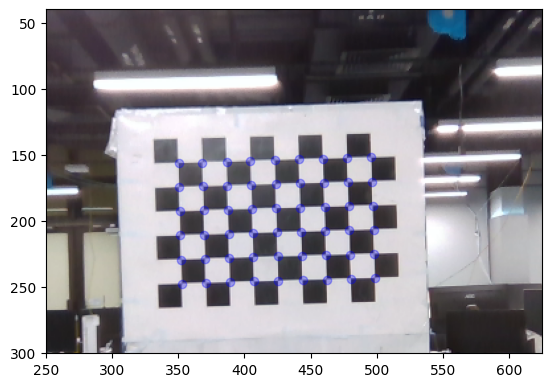

In [15]:
plt.figure()
plt.imshow(chest_img)
for u,v in corners:
    plt.scatter(u,v, color='blue',alpha=0.3)
plt.xlim([250, 625])
plt.ylim([300, 40])

In [16]:
# Transformation for the shifting of the center

T_chest_cam_ctr = np.eye(4)
T_chest_cam_ctr[0, -1] = -0.0325  # chest rgb to module center, 32.5 mm
T_chest_cam_ctr

array([[ 1.    ,  0.    ,  0.    , -0.0325],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [17]:
# Transformation: Board to Chest Image

T_chest = get_camera_pose(chest_img, obj_pts, chest_cam_camera_mtx, chest_cam_dist_coef)

# 2nd Filtering: RMSE and Motion Blur

## Left Eye

In [18]:
# Board to Left Eye Camera

img_left_list = filt_df['left_eye_img'].tolist()
T_left_list = []
for img in img_left_list:
    T_left_list.append(get_camera_pose(img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))
filt_df['T_bl'] = T_left_list

In [19]:
rmse_left_list = []
for i in range(len(T_left_list)):
    T = T_left_list[i]
    img = img_left_list[i]
    rmse_left_list.append(get_rmse_pose(T, img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))
filt_df['rmse_left'] = rmse_left_list

In [20]:
%matplotlib widget

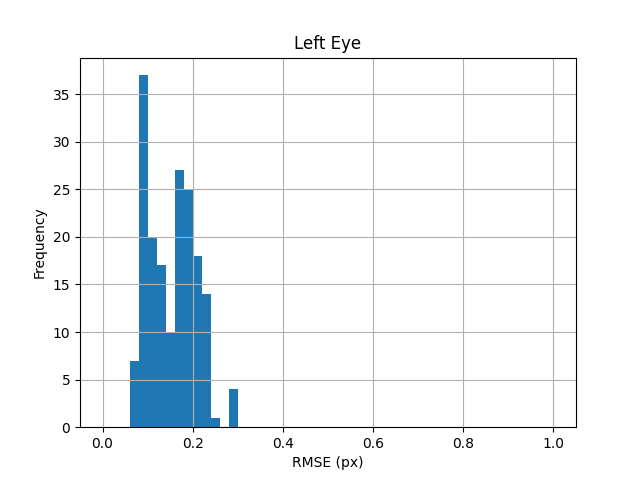

In [21]:
# Before Thresholding

plt.figure()
plt.hist(rmse_left_list, range=(0,1), bins=50)
plt.xlabel('RMSE (px)')
plt.ylabel('Frequency')
plt.title('Left Eye')
plt.grid()

In [22]:
# Remove Bad Batch

filt_df = filt_df.drop(filt_df[filt_df['rmse_left'] > 0.27].index).reset_index(drop=True)
filt_df.head()

chess_idx theta_left_pan theta_right_pan theta_tilt   
0          4           None            None       None  \
1          8           None            None       None   
2          4           None            None       None   
3          0           None            None       None   
4          4           None            None       None   

   chest_cam_px_x_tminus1  chest_cam_px_y_tminus1  left_eye_px_x_tminus1   
0              386.624451              155.395966             493.580688  \
1              459.459869              153.038849             552.453674   
2              459.465179              152.996948             530.551758   
3              386.636475              155.412720             429.377716   
4              386.622284              155.423111             406.640930   

   left_eye_px_y_tminus1  right_eye_px_x_tminus1  right_eye_px_y_tminus1  ...   
0             227.238266              315.146820              239.204834  ...  \
1             228.914917              366.586395              241.918472  ...   
2             229.196640              347.604401              241.752594  ...   
3             228.090088              255.699310              238.524719  ...   
4             228.184830              233.475357              238.274261  ...   

   theta_neck_pan_cmd_tminus2  theta_upper_tilt_left_cmd_tminus2   
0                         -35                                 57  \
1                         -35                                 57   
2                         -35                                 57   
3                         -35                                 57   
4                         -35                                 57   

   theta_neck_pan_cmd_tminus1  theta_upper_tilt_left_cmd_tminus1   
0                         -12                                  0  \
1                         -10                                  0   
2                          -8                                  0   
3                          -6                                  0   
4                          -4                                  0   

   theta_upper_tilt_right_cmd_tminus1  phi_direction_left_pan   
0                                   0                       3  \
1                                   0                       3   
2                                   0                       3   
3                                   0                       3   
4                                   0                       3   

   phi_direction_right_pan  phi_direction_tilt   
0                        3                   3  \
1                        3                   3   
2                        3                   3   
3                        3                   3   
4                        3                   3   

                                                T_bl  rmse_left  
0  [[0.9340631172229817, 0.011318978131828722, -0...   0.185918  
1  [[0.9405036213779705, 0.010032793105550634, -0...   0.171780  
2  [[0.9490394666420053, 0.009736464045024073, -0...   0.151603  
3  [[0.9561768417147003, 0.010145774490166064, -0...   0.134226  
4  [[0.9646498864828641, 0.008656613009244748, -0...   0.112650  

[5 rows x 68 columns]

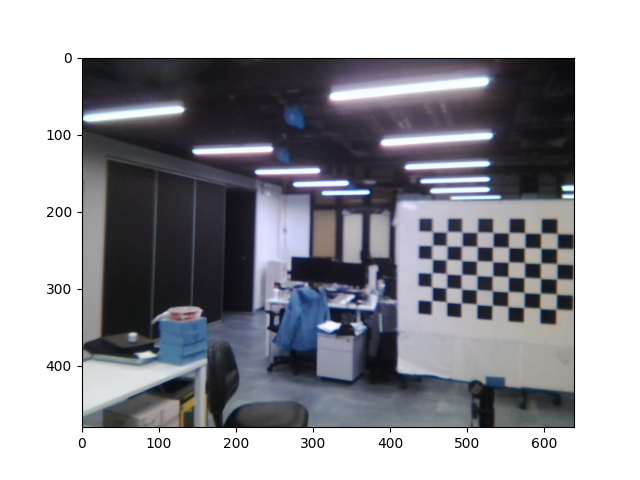

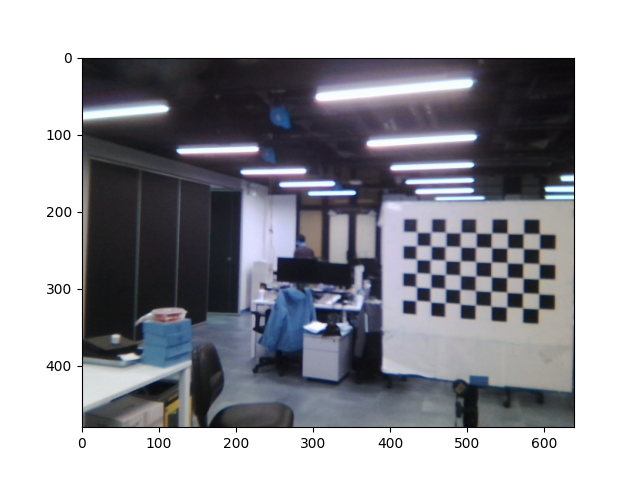

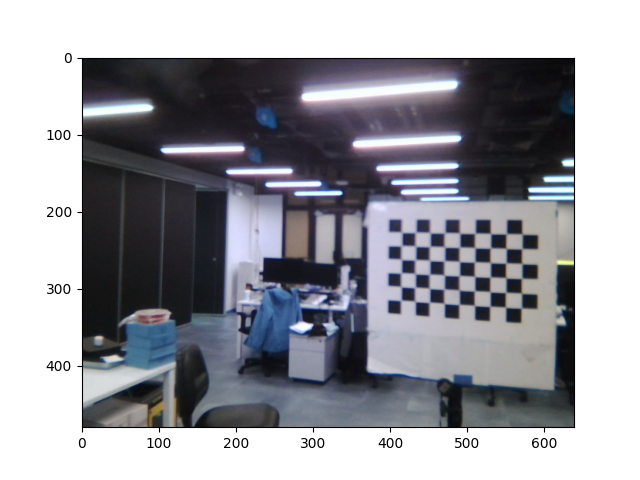

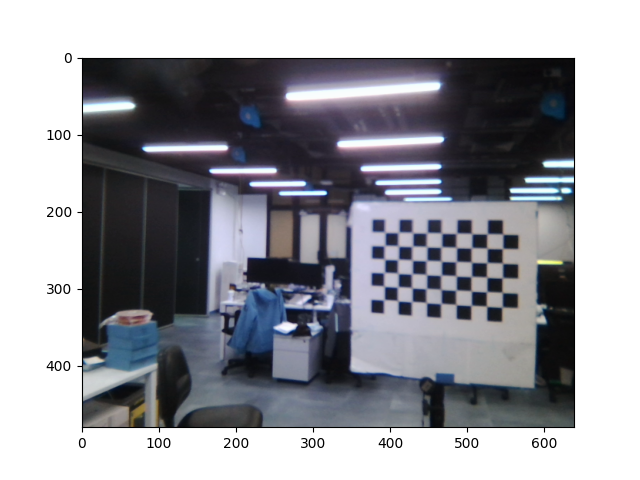

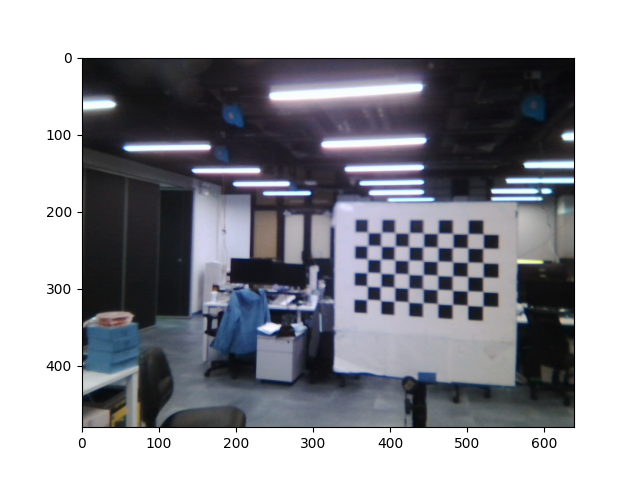

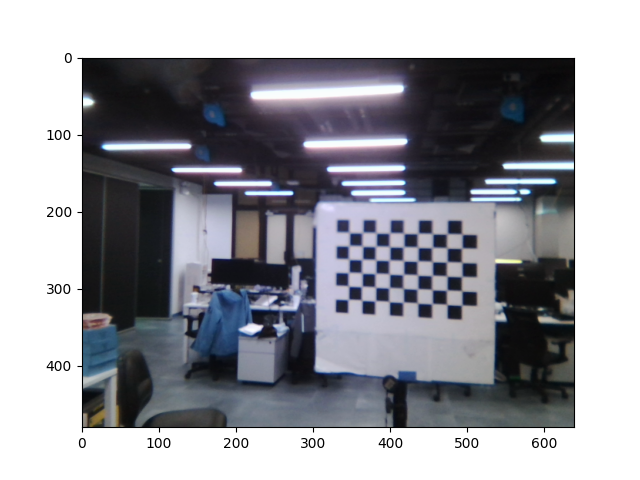

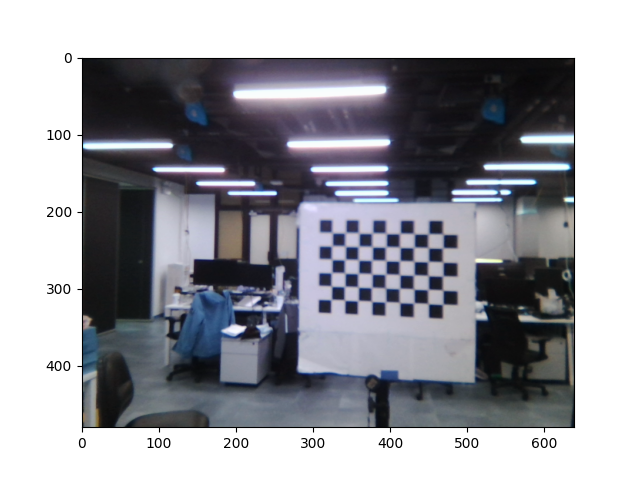

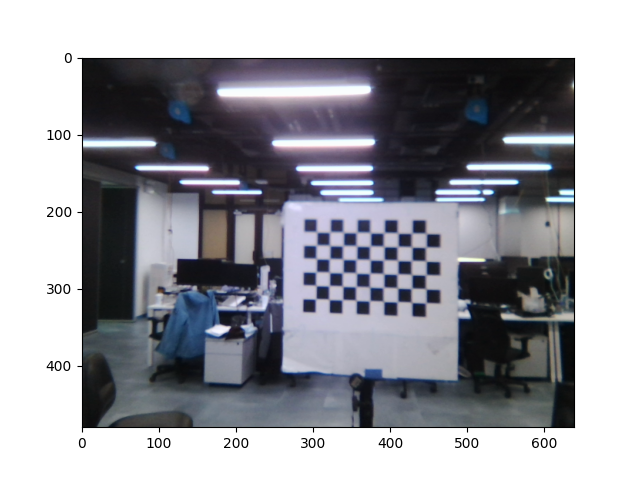

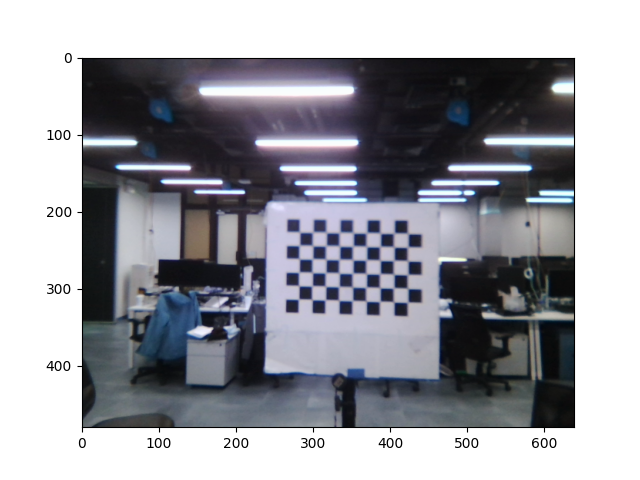

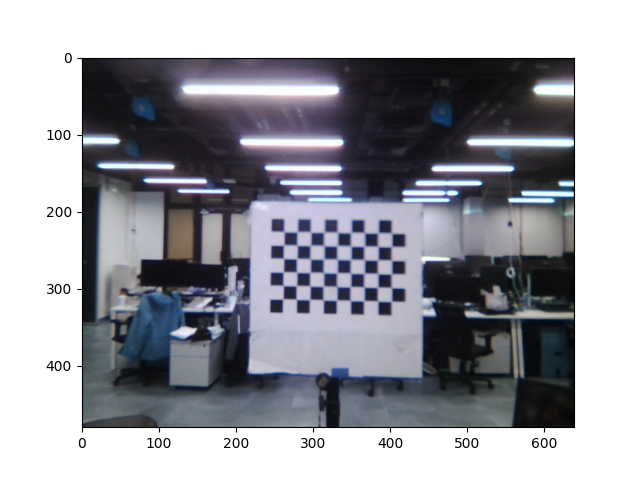

In [23]:
for img in filt_df['left_eye_img'][:10]:
    plt.figure()
    plt.imshow(img)

## Right Eye

In [24]:
img_right_list = filt_df['right_eye_img'].tolist()
T_right_list = []
for img in img_right_list:
    T_right_list.append(get_camera_pose(img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))
filt_df['T_br'] = T_right_list

In [25]:
rmse_right_list = []
for i in range(len(T_right_list)):
    T = T_right_list[i]
    img = img_right_list[i]
    rmse_right_list.append(get_rmse_pose(T, img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))
filt_df['rmse_right'] = rmse_right_list

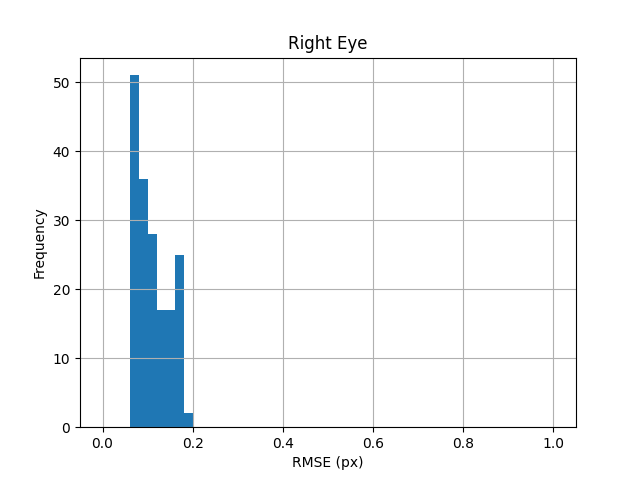

In [26]:
plt.figure()
plt.hist(rmse_right_list, range=(0,1), bins=50)
plt.xlabel('RMSE (px)')
plt.ylabel('Frequency')
plt.title('Right Eye')
plt.grid()

In [27]:
# Remove Bad Batch

filt_df = filt_df.drop(filt_df[filt_df['rmse_right'] > 0.25].index).reset_index(drop=True)
filt_df.head()

chess_idx theta_left_pan theta_right_pan theta_tilt   
0          4           None            None       None  \
1          8           None            None       None   
2          4           None            None       None   
3          0           None            None       None   
4          4           None            None       None   

   chest_cam_px_x_tminus1  chest_cam_px_y_tminus1  left_eye_px_x_tminus1   
0              386.624451              155.395966             493.580688  \
1              459.459869              153.038849             552.453674   
2              459.465179              152.996948             530.551758   
3              386.636475              155.412720             429.377716   
4              386.622284              155.423111             406.640930   

   left_eye_px_y_tminus1  right_eye_px_x_tminus1  right_eye_px_y_tminus1  ...   
0             227.238266              315.146820              239.204834  ...  \
1             228.914917              366.586395              241.918472  ...   
2             229.196640              347.604401              241.752594  ...   
3             228.090088              255.699310              238.524719  ...   
4             228.184830              233.475357              238.274261  ...   

   theta_neck_pan_cmd_tminus1  theta_upper_tilt_left_cmd_tminus1   
0                         -12                                  0  \
1                         -10                                  0   
2                          -8                                  0   
3                          -6                                  0   
4                          -4                                  0   

   theta_upper_tilt_right_cmd_tminus1  phi_direction_left_pan   
0                                   0                       3  \
1                                   0                       3   
2                                   0                       3   
3                                   0                       3   
4                                   0                       3   

   phi_direction_right_pan  phi_direction_tilt   
0                        3                   3  \
1                        3                   3   
2                        3                   3   
3                        3                   3   
4                        3                   3   

                                                T_bl  rmse_left   
0  [[0.9340631172229817, 0.011318978131828722, -0...   0.185918  \
1  [[0.9405036213779705, 0.010032793105550634, -0...   0.171780   
2  [[0.9490394666420053, 0.009736464045024073, -0...   0.151603   
3  [[0.9561768417147003, 0.010145774490166064, -0...   0.134226   
4  [[0.9646498864828641, 0.008656613009244748, -0...   0.112650   

                                                T_br  rmse_right  
0  [[0.9926623600284129, 0.033094195223947444, -0...    0.074739  
1  [[0.9960015571146627, 0.034211267996615065, -0...    0.073586  
2  [[0.9979638876600203, 0.035064599103459, -0.05...    0.072192  
3  [[0.999075177652622, 0.03677695762145661, -0.0...    0.072017  
4  [[0.9991717727537549, 0.03691084128393674, 0.0...    0.072614  

[5 rows x 70 columns]

## Summary

In [28]:
# Unique Values

print(filt_df['theta_neck_pan_cmd_tminus1'].unique())
print(filt_df['theta_upper_tilt_left_cmd_tminus1'].unique())
print(filt_df['theta_upper_tilt_right_cmd_tminus1'].unique())

[-12 -10  -8  -6  -4  -2   0   2   4   6]
[ 0  5 10 15]
[  0  -5 -10 -15]


In [29]:
# Left Eye

combined_counts = filt_df.groupby(['theta_upper_tilt_left_cmd_tminus1','theta_neck_pan_cmd_tminus1']).size().reset_index(name='count')
df = pd.DataFrame(combined_counts)
pd.set_option('display.max_rows', None)
df

theta_upper_tilt_left_cmd_tminus1  theta_neck_pan_cmd_tminus1  count
0                                   0                         -12      5
1                                   0                         -10      5
2                                   0                          -8      5
3                                   0                          -6      5
4                                   0                          -4      5
5                                   0                          -2      5
6                                   0                           0      5
7                                   0                           2      5
8                                   0                           4      5
9                                   0                           6      5
10                                  5                         -12      5
11                                  5                         -10      5
12                                  5                          -8      5
13                                  5                          -6      5
14                                  5                          -4      5
15                                  5                          -2      5
16                                  5                           0      5
17                                  5                           2      5
18                                  5                           4      5
19                                  5                           6      5
20                                 10                         -12      4
21                                 10                         -10      4
22                                 10                          -8      4
23                                 10                          -6      4
24                                 10                          -4      4
25                                 10                          -2      4
26                                 10                           0      4
27                                 10                           2      4
28                                 10                           4      4
29                                 10                           6      4
30                                 15                         -10      4
31                                 15                          -8      4
32                                 15                          -6      4
33                                 15                          -4      4
34                                 15                          -2      4
35                                 15                           0      4
36                                 15                           2      4
37                                 15                           4      4
38                                 15                           6      4

In [30]:
# Right Eye

combined_counts = filt_df.groupby(['theta_upper_tilt_right_cmd_tminus1', 'theta_neck_pan_cmd_tminus1']).size().reset_index(name='count')
df = pd.DataFrame(combined_counts)
pd.set_option('display.max_rows', None)
df

theta_upper_tilt_right_cmd_tminus1  theta_neck_pan_cmd_tminus1  count
0                                  -15                         -12      4
1                                  -15                         -10      4
2                                  -15                          -8      4
3                                  -15                          -6      4
4                                  -15                          -4      4
5                                  -15                          -2      4
6                                  -15                           0      4
7                                  -15                           2      4
8                                  -15                           4      4
9                                  -15                           6      4
10                                 -10                         -10      4
11                                 -10                          -8      4
12                                 -10                          -6      4
13                                 -10                          -4      4
14                                 -10                          -2      4
15                                 -10                           0      4
16                                 -10                           2      4
17                                 -10                           4      4
18                                 -10                           6      4
19                                  -5                         -12      4
20                                  -5                         -10      5
21                                  -5                          -8      5
22                                  -5                          -6      5
23                                  -5                          -4      5
24                                  -5                          -2      5
25                                  -5                           0      5
26                                  -5                           2      5
27                                  -5                           4      5
28                                  -5                           6      5
29                                   0                         -12      6
30                                   0                         -10      5
31                                   0                          -8      5
32                                   0                          -6      5
33                                   0                          -4      5
34                                   0                          -2      5
35                                   0                           0      5
36                                   0                           2      5
37                                   0                           4      5
38                                   0                           6      5

# Left Eye Gaze Center Calculation 

In [31]:
# Left Eye

gx_left = calib_params['left_eye']['x_center']
gy_left = calib_params['left_eye']['y_center']

fx_left = left_eye_camera_mtx[0][0]
cx_left = left_eye_camera_mtx[0][2]
fy_left = left_eye_camera_mtx[1][1]
cy_left = left_eye_camera_mtx[1][2]

print('gx_left:', gx_left)
print('cx_left:',cx_left)
print('gy_left:',gy_left)
print('cy_left',cy_left)

gx_left: 360.6
cx_left: 302.45664072
gy_left: 224.7
cy_left 215.54188413


In [32]:
# Calculation of the angles

yaw_left = math.degrees(math.atan((gx_left-cx_left)/fx_left))
pitch_left = math.degrees(math.atan((cy_left-gy_left)/fy_left))

print('yaw_left (deg):', yaw_left)
print('pitch_left (deg):', pitch_left)

yaw_left (deg): 5.868985228595727
pitch_left (deg): -0.929092772858488


In [33]:
# Transformation: Gaze Center Left to Left'

r1 = R.from_euler("zyx", [0, yaw_left, pitch_left], degrees=True)
T_gaze_ctr_left = np.eye(4)
T_gaze_ctr_left[:3,:3] = r1.as_matrix()

print('Gaze Center Left Eye:',T_gaze_ctr_left)
print('Gaze Center to Euler:',r1.as_euler('zyx', degrees=True))

Gaze Center Left Eye: [[ 9.94758314e-01  1.08420217e-19  1.02254079e-01  0.00000000e+00]
 [-1.65805166e-03  9.99868528e-01  1.61300233e-02  0.00000000e+00]
 [-1.02240636e-01 -1.62150173e-02  9.94627531e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Gaze Center to Euler: [ 0.          5.86898523 -0.92909277]


# Left Eye Transformation to Chest RGB Camera

In [34]:
# Final Left Eye List

T_chest_rgb_left_list = []
for T_left in filt_df['T_bl']:
    T_chest_rgb_left_list.append(chest_rgb_to_eye(T_chest,T_left))
    
filt_df['T_chest_rgb_left_eye'] = T_chest_rgb_left_list

In [35]:
# Left Eye Zero Position

left_df = filt_df[(filt_df['theta_tilt_cmd_tminus1']==0) 
                  & (filt_df['theta_left_pan_cmd_tminus1']==0)].reset_index()
left_zero_T = np.mean(left_df['T_chest_rgb_left_eye'])
print('T Chest RGB Left Eye:',left_zero_T)

T Chest RGB Left Eye: [[ 0.96826482  0.03298373 -0.22745772  0.01224346]
 [-0.05461653  0.99262405 -0.09162404 -0.2105776 ]
 [ 0.22305164  0.10162636  0.96285333  0.01796543]
 [ 0.          0.          0.          1.        ]]


# -------------------------------------------------------------------------------------

# Right Eye Gaze Center Calculation

In [36]:
# Right Eye

gx_right = calib_params['right_eye']['x_center']
gy_right = calib_params['right_eye']['y_center']

fx_right = right_eye_camera_mtx[0][0]
cx_right = right_eye_camera_mtx[0][2]
fy_right = right_eye_camera_mtx[1][1]
cy_right = right_eye_camera_mtx[1][2]

print('gx_right:', gx_right)
print('cx_right:',cx_right)
print('gy_right:',gy_right)
print('cy_right',cy_right)

gx_right: 222.3
cx_right: 301.5981296
gy_right: 235.9
cy_right 214.24971323


In [37]:
# Calculation of the angles

yaw_right = math.degrees(math.atan((gx_right-cx_right)/fx_right))
pitch_right = math.degrees(math.atan((cy_right-gy_right)/fy_right))

print('yaw_right (deg):', yaw_right)
print('pitch_right (deg):', pitch_right)

yaw_right (deg): -7.9146930152243264
pitch_right (deg): -2.175626509301668


In [38]:
# Gaze Center Right

r2 = R.from_euler("zyx", [0, yaw_right, pitch_right], degrees=True)
T_gaze_ctr_right = np.eye(4)
T_gaze_ctr_right[:3,:3] = r2.as_matrix()
print('Gaze Center Right Eye:',T_gaze_ctr_right)
print(r2.as_euler('zyx', degrees=True))

Gaze Center Right Eye: [[ 9.90474184e-01 -4.33680869e-19 -1.37698549e-01  0.00000000e+00]
 [ 5.22741168e-03  9.99279156e-01  3.76010956e-02  0.00000000e+00]
 [ 1.37599290e-01 -3.79627215e-02  9.89760207e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 0.         -7.91469302 -2.17562651]


# Right Eye Transformation to Chest RGB Camera

In [39]:
# Final Right Eye List

T_chest_rgb_right_list = []
for T_right in filt_df['T_br']:
    T_chest_rgb_right_list.append(chest_rgb_to_eye(T_chest,T_right))
    
filt_df['T_chest_rgb_right_eye'] = T_chest_rgb_right_list

In [40]:
# Right Eye Zero Position

right_df = filt_df[(filt_df['theta_tilt_cmd_tminus1']==0) 
                  & (filt_df['theta_right_pan_cmd_tminus1']==0)].reset_index()
right_zero_T = np.mean(right_df['T_chest_rgb_right_eye'])
print('T Chest RGB Right Eye:',right_zero_T)

T Chest RGB Right Eye: [[ 0.99215602  0.06101907  0.04020613  0.05329606]
 [-0.05438255  0.98693957 -0.1378615  -0.19410798]
 [-0.04781005  0.13522351  0.98249338  0.02106066]
 [ 0.          0.          0.          1.        ]]


# -------------------------------------------------------------------------------------

# Plotting

In [41]:
%matplotlib widget

Add the depth discrepancy (-0.0042m or the Z value offset to realsense glass) here for the get_chess_obj_pts

In [42]:
# Get Depth Object Points

depth_obj_pts = get_chess_obj_pts(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)

(-0.2, 2.0)

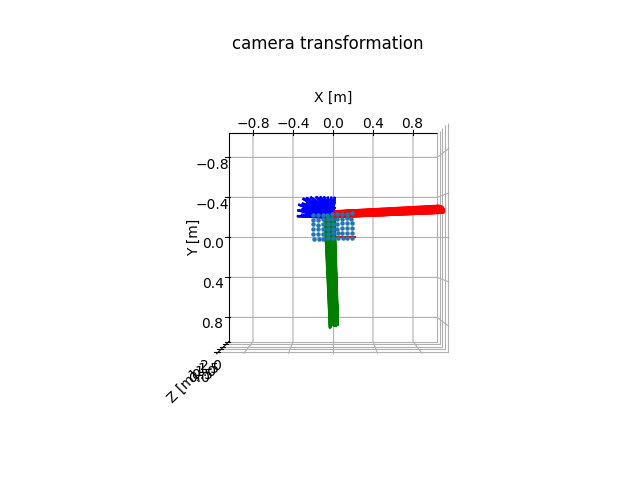

In [43]:
# Transformed Left Eye Camera

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left Poses
for T in filt_df['T_chest_rgb_left_eye']:
    T = np.matmul(T_chest_cam_ctr, T)  # T_ol = T_oc x T_cl
    T = np.matmul(T, T_gaze_ctr_left)  # T_ol' = T_ol x T_ll'
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

(-0.2, 2.0)

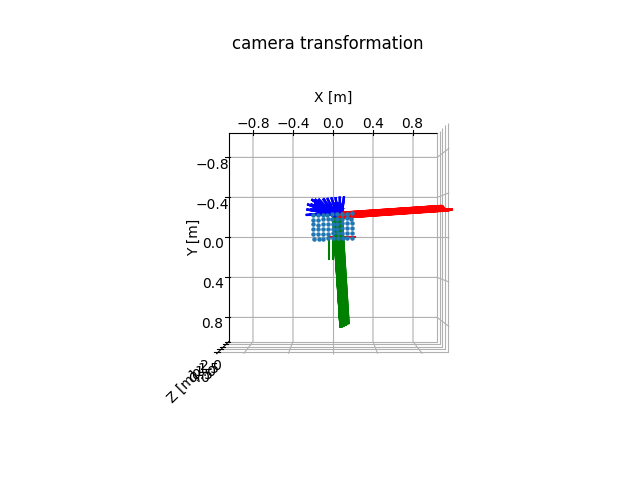

In [44]:
# Transformed Right Eye Camera

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left Poses
for T in filt_df['T_chest_rgb_right_eye']:
    T = np.matmul(T_chest_cam_ctr, T)  # T_or = T_oc x T_cr
    T = np.matmul(T, T_gaze_ctr_right)  # T_or' = T_or x T_rr'
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

# Slope/Gain Calculation

## Left Eye

In [45]:
# Rotation

pitch_list = []
yaw_list = []
roll_list = []
for i in range(len(filt_df)):
    rmat = filt_df['T_chest_rgb_left_eye'][i][:3,:3]
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    pitch_list.append(angles[0])
    yaw_list.append(angles[1])
    roll_list.append(angles[2])
filt_df['left_pitch'] = pitch_list
filt_df['left_yaw'] = yaw_list
filt_df['left_roll'] = roll_list

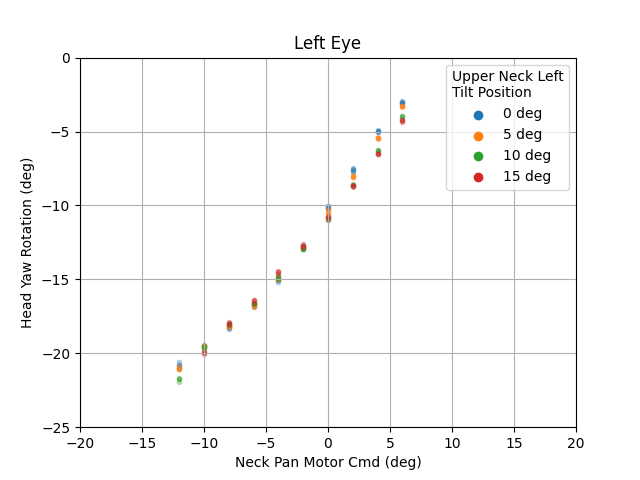

In [46]:
# Pan Slope Plot

plt.figure()

tilt_cmd_list = list(range(0,16,5))
for i in range(len(tilt_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_upper_tilt_left_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    plt.scatter(df['theta_neck_pan_cmd_tminus1'], df['left_yaw'], alpha=0.3, marker='.', color=colors[i])

# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Neck Pan Motor Cmd (deg)')
plt.ylabel('Head Yaw Rotation (deg)')
plt.xlim([-20, 20])
plt.ylim([-25, 0])
plt.grid()
plt.title('Left Eye')
plt.legend(['%i deg' % (i) for i in tilt_cmd_list], title='Upper Neck Left\nTilt Position')

In [47]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_upper_tilt_left_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    X = df['theta_neck_pan_cmd_tminus1'].values.reshape(-1,1)
    y = df['left_yaw'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [1.0220909164234568, 1.001235969563561, 0.9677550346370422, 0.9711434290448736]
Intercept List: [-9.817701525430067, -10.04411903862562, -10.467740940725129, -10.495606076047292]


Text(0, 0.5, 'm_lpan (yaw/cmd)')

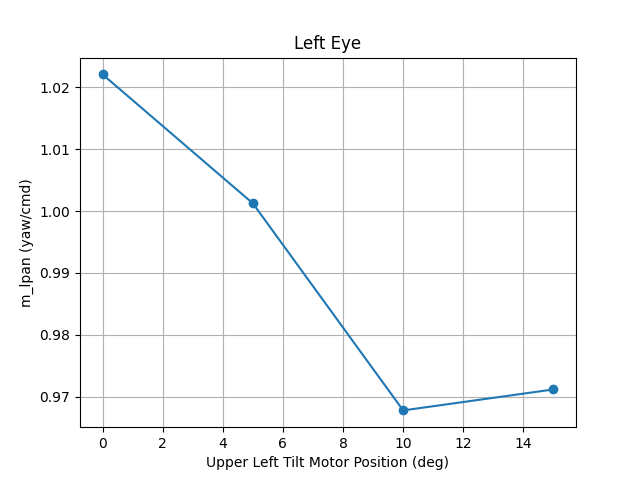

In [48]:
# Slope Plot

plt.figure()
plt.plot(tilt_cmd_list, coef_list, marker='o')
plt.title('Left Eye')
plt.grid()
plt.xlabel('Upper Left Tilt Motor Position (deg)')
plt.ylabel('m_lpan (yaw/cmd)')

In [49]:
# Mean Left Eye Pan Slope

mean_left_eye_pan_slope = np.mean(coef_list)
print('Mean Left Eye Neck Pan Slope:', mean_left_eye_pan_slope)

Mean Left Eye Neck Pan Slope: 0.9905563374172334


## Right Eye

In [50]:
# Rotation

pitch_list = []
yaw_list = []
roll_list = []
for i in range(len(filt_df)):
    rmat = filt_df['T_chest_rgb_right_eye'][i][:3,:3]
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    pitch_list.append(angles[0])
    yaw_list.append(angles[1])
    roll_list.append(angles[2])
filt_df['right_pitch'] = pitch_list
filt_df['right_yaw'] = yaw_list
filt_df['right_roll'] = roll_list

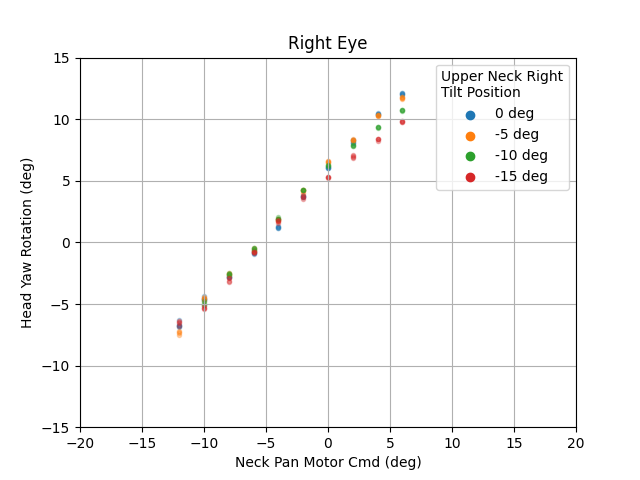

In [51]:
# Pan Slope Plot

plt.figure()

tilt_cmd_list = list(range(0,-16,-5))
for i in range(len(tilt_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_upper_tilt_right_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    plt.scatter(df['theta_neck_pan_cmd_tminus1'], df['right_yaw'], alpha=0.3, marker='.', color=colors[i])

# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Neck Pan Motor Cmd (deg)')
plt.ylabel('Head Yaw Rotation (deg)')
plt.xlim([-20, 20])
plt.ylim([-15, 15])
plt.grid()
plt.title('Right Eye')
plt.legend(['%i deg' % (i) for i in tilt_cmd_list], title='Upper Neck Right\nTilt Position')

In [52]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_upper_tilt_right_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    X = df['theta_neck_pan_cmd_tminus1'].values.reshape(-1,1)
    y = df['right_yaw'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [1.0645554630664817, 1.069053895601078, 0.9964377066335883, 0.947133190020734]
Intercept List: [5.881817612672782, 6.010834705736443, 5.589809618351687, 4.857157180211058]


Text(0, 0.5, 'm_rpan (yaw/cmd)')

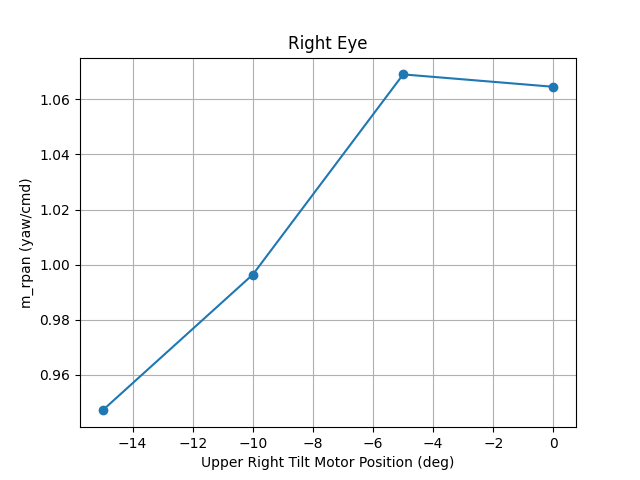

In [53]:
# Slope Plot

plt.figure()
plt.plot(tilt_cmd_list, coef_list, marker='o')
plt.title('Right Eye')
plt.grid()
plt.xlabel('Upper Right Tilt Motor Position (deg)')
plt.ylabel('m_rpan (yaw/cmd)')

In [54]:
# Mean Right Eye Pan Slope

mean_right_eye_pan_slope = np.mean(coef_list)
print('Mean Right Eye Neck Pan Slope:', mean_right_eye_pan_slope)

Mean Right Eye Neck Pan Slope: 1.0192950638304705


## Average Pan

In [55]:
# Average pan

mean_neck_pan_slope = (mean_left_eye_pan_slope + mean_right_eye_pan_slope)/2
print('Mean Neck Pan Slope:', mean_neck_pan_slope)

Mean Neck Pan Slope: 1.004925700623852


## Tilt Slope Left

### Upper Neck Left

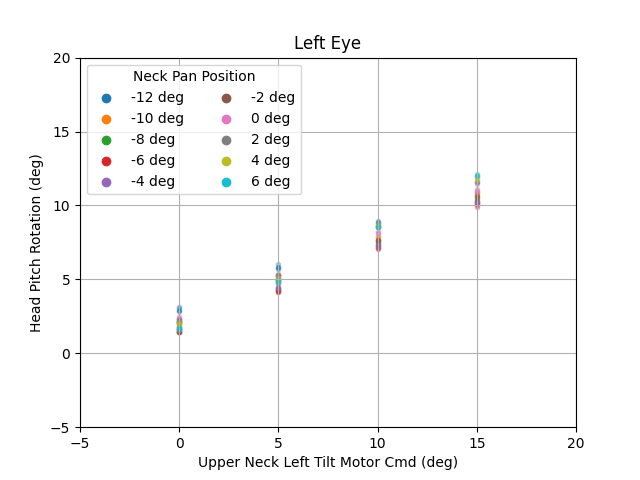

In [56]:
# Tilt Slope Left

plt.figure()

left_pan_cmd_list = list(range(-12,7,2))
for i in range(len(left_pan_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    plt.scatter(df['theta_upper_tilt_left_cmd_tminus1'], df['left_pitch'], alpha=0.3, marker='.', color=colors[i])
    
# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Upper Neck Left Tilt Motor Cmd (deg)')
plt.ylabel('Head Pitch Rotation (deg)')
plt.xlim([-5, 20])
plt.ylim([-5, 20])
plt.title('Left Eye')
plt.legend(['%i deg' % (i) for i in left_pan_cmd_list], title='Neck Pan Position', ncol=2)
plt.grid()

In [57]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    X = df['theta_upper_tilt_left_cmd_tminus1'].values.reshape(-1,1)
    y = df['left_pitch'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [0.589673818398068, 0.5792036457695787, 0.587484017021852, 0.5759049383924542, 0.5693629028488794, 0.5639053399053652, 0.5763160186683932, 0.6265161398185599, 0.6634808690303365, 0.6973333915647941]
Intercept List: [2.93348579760441, 2.016246144800811, 1.4935491113122197, 1.397491332285857, 1.6249417547043574, 2.116995528948763, 2.3919390906736213, 2.2022502294307937, 1.8897714281736775, 1.5450690565645937]


Text(0, 0.5, 'm_tilt (pitch/cmd)')

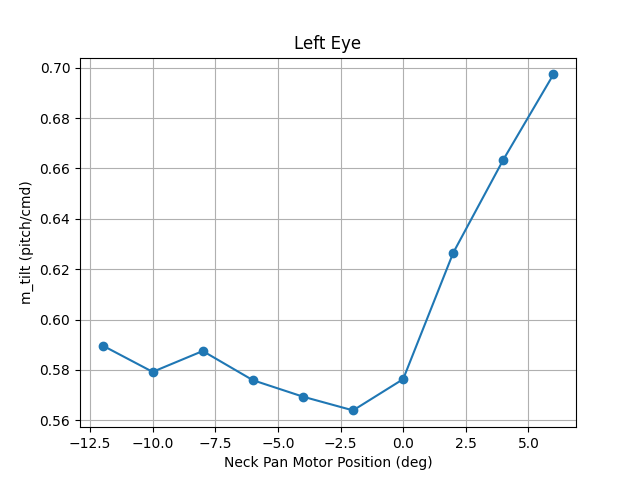

In [58]:
# Slope Plot

plt.figure()
plt.plot(left_pan_cmd_list, coef_list, marker='o')
plt.title('Left Eye')
plt.grid()
plt.xlabel('Neck Pan Motor Position (deg)')
plt.ylabel('m_tilt (pitch/cmd)')
#plt.ylim([0,1])

In [59]:
# Mean Left Eye Tilt Slope

mean_left_eye_tilt_slope_upper_left = np.mean(coef_list)
print('Mean Left Eye Tilt Slope Upper Left:', mean_left_eye_tilt_slope_upper_left)

Mean Left Eye Tilt Slope Upper Left: 0.6029181081418281


### Upper Neck Right

/tmp/ipykernel_362641/3783195098.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


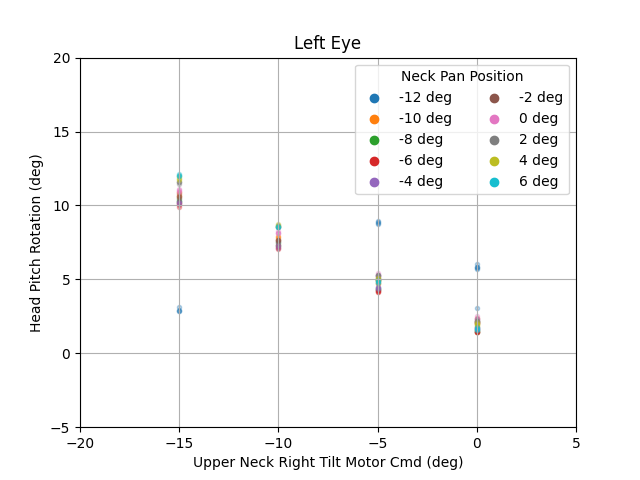

In [60]:
# Tilt Slope Left

plt.figure()

left_pan_cmd_list = list(range(-12,7,2))
for i in range(len(left_pan_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    plt.scatter(df['theta_upper_tilt_right_cmd_tminus1'], df['left_pitch'], alpha=0.3, marker='.', color=colors[i])
    
# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Upper Neck Right Tilt Motor Cmd (deg)')
plt.ylabel('Head Pitch Rotation (deg)')
plt.xlim([-20, 5])
plt.ylim([-5, 20])
plt.title('Left Eye')
plt.legend(['%i deg' % (i) for i in left_pan_cmd_list], title='Neck Pan Position', ncol=2)
plt.grid()

In [61]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    X = df['theta_upper_tilt_right_cmd_tminus1'].values.reshape(-1,1)
    y = df['left_pitch'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [0.18517115103639062, -0.5792036457695787, -0.587484017021852, -0.5759049383924542, -0.5693629028488794, -0.5639053399053652, -0.5763160186683932, -0.6265161398185599, -0.6634808690303365, -0.6973333915647941]
Intercept List: [6.729377960374816, 2.016246144800811, 1.4935491113122197, 1.397491332285857, 1.6249417547043574, 2.116995528948763, 2.3919390906736213, 2.2022502294307937, 1.8897714281736775, 1.5450690565645937]


Text(0, 0.5, 'm_tilt (pitch/cmd)')

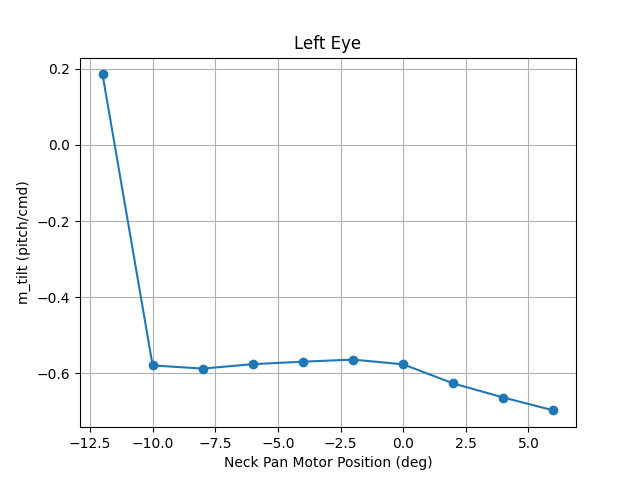

In [62]:
# Slope Plot

plt.figure()
plt.plot(left_pan_cmd_list, coef_list, marker='o')
plt.title('Left Eye')
plt.grid()
plt.xlabel('Neck Pan Motor Position (deg)')
plt.ylabel('m_tilt (pitch/cmd)')
#plt.ylim([0,1])

In [63]:
# Mean Right Eye Tilt Slope

mean_right_eye_tilt_slope_upper_right = np.mean(coef_list[1:])
print('Mean Right Eye Tilt Slope Upper Right:', mean_right_eye_tilt_slope_upper_right)

Mean Right Eye Tilt Slope Upper Right: -0.6043896958911348


### Total Mean Slope

In [64]:
# Mean Left Eye Tilt Slope

mean_left_total_tilt_slope = (abs(mean_left_eye_tilt_slope_upper_left) 
                              + abs(mean_right_eye_tilt_slope_upper_right))/2
print('Mean Left Total Tilt Slope:', mean_left_total_tilt_slope)

Mean Left Total Tilt Slope: 0.6036539020164815


## Tilt Slope Right

### Upper Neck Left

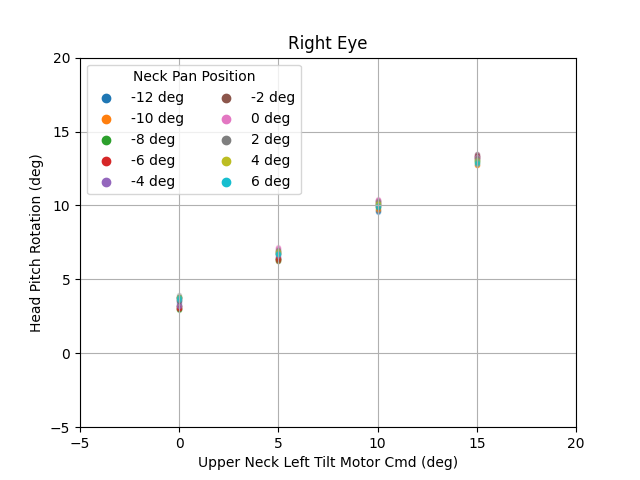

In [65]:
# Tilt Slope Left

plt.figure()

left_pan_cmd_list = list(range(-12,7,2))
for i in range(len(left_pan_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    plt.scatter(df['theta_upper_tilt_left_cmd_tminus1'], df['right_pitch'], alpha=0.3, marker='.', color=colors[i])
    
# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Upper Neck Left Tilt Motor Cmd (deg)')
plt.ylabel('Head Pitch Rotation (deg)')
plt.xlim([-5, 20])
plt.ylim([-5, 20])
plt.title('Right Eye')
plt.legend(['%i deg' % (i) for i in left_pan_cmd_list], title='Neck Pan Position', ncol=2)
plt.grid()

In [66]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    X = df['theta_upper_tilt_left_cmd_tminus1'].values.reshape(-1,1)
    y = df['right_pitch'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [0.6389920049309608, 0.6445852807476208, 0.6740254542847607, 0.6858065594212679, 0.6731929215729296, 0.6562633537833719, 0.6371826734705848, 0.6281576737818302, 0.6201130516218938, 0.6162749645040007]
Intercept List: [3.2224358680108485, 3.168761301306617, 3.0093307014954203, 3.0367792130950617, 3.3080911351352364, 3.606719809924402, 3.8357433503445177, 3.8277947795376246, 3.7774621325446365, 3.702051870335909]


Text(0, 0.5, 'm_tilt (pitch/cmd)')

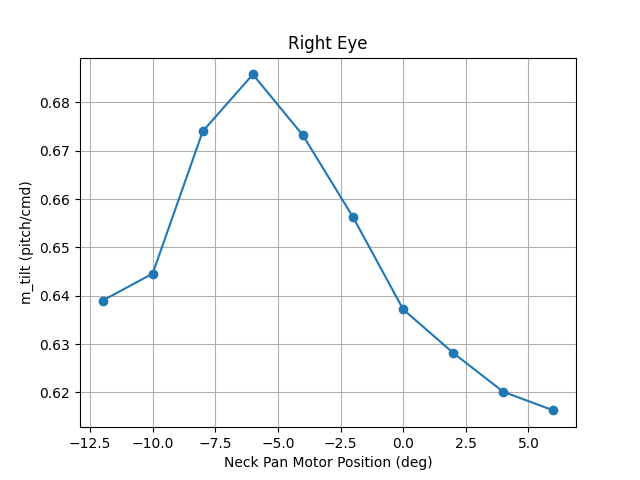

In [67]:
# Slope Plot

plt.figure()
plt.plot(left_pan_cmd_list, coef_list, marker='o')
plt.title('Right Eye')
plt.grid()
plt.xlabel('Neck Pan Motor Position (deg)')
plt.ylabel('m_tilt (pitch/cmd)')
#plt.ylim([0,1])

In [68]:
# Mean Left Eye Tilt Slope

mean_left_eye_tilt_slope_upper_left = np.mean(coef_list)
print('Mean Left Eye Tilt Slope Upper Left:', mean_left_eye_tilt_slope_upper_left)

Mean Left Eye Tilt Slope Upper Left: 0.6474593938119222


### Upper Neck Right

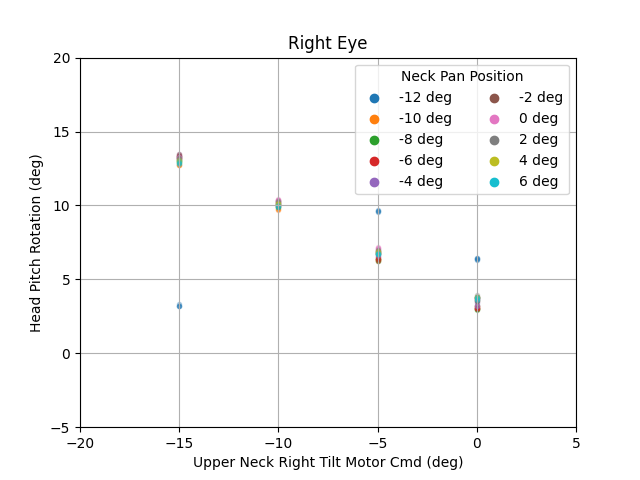

In [69]:
# Tilt Slope Left

plt.figure()

left_pan_cmd_list = list(range(-12,7,2))
for i in range(len(left_pan_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    plt.scatter(df['theta_upper_tilt_right_cmd_tminus1'], df['right_pitch'], alpha=0.3, marker='.', color=colors[i])
    
# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Upper Neck Right Tilt Motor Cmd (deg)')
plt.ylabel('Head Pitch Rotation (deg)')
plt.xlim([-20, 5])
plt.ylim([-5, 20])
plt.title('Right Eye')
plt.legend(['%i deg' % (i) for i in left_pan_cmd_list], title='Neck Pan Position', ncol=2)
plt.grid()

In [70]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_neck_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    X = df['theta_upper_tilt_right_cmd_tminus1'].values.reshape(-1,1)
    y = df['right_pitch'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [0.19984704335143474, -0.6445852807476208, -0.6740254542847607, -0.6858065594212679, -0.6731929215729296, -0.6562633537833719, -0.6371826734705848, -0.6281576737818302, -0.6201130516218938, -0.6162749645040007]
Intercept List: [7.3311675671985075, 3.168761301306617, 3.0093307014954203, 3.0367792130950617, 3.3080911351352364, 3.606719809924402, 3.8357433503445177, 3.8277947795376246, 3.7774621325446365, 3.702051870335909]


Text(0, 0.5, 'm_tilt (pitch/cmd)')

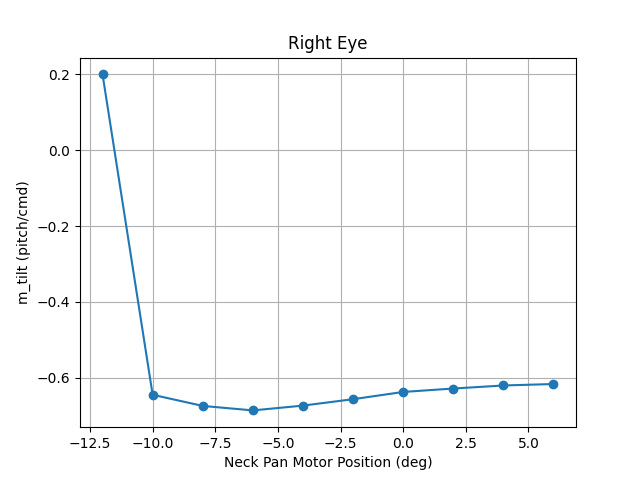

In [71]:
# Slope Plot

plt.figure()
plt.plot(left_pan_cmd_list, coef_list, marker='o')
plt.title('Right Eye')
plt.grid()
plt.xlabel('Neck Pan Motor Position (deg)')
plt.ylabel('m_tilt (pitch/cmd)')
#plt.ylim([0,1])

In [72]:
# Mean Right Eye Tilt Slope

mean_right_eye_tilt_slope_upper_right = np.mean(coef_list[1:])
print('Mean Right Eye Tilt Slope Upper Right:', mean_right_eye_tilt_slope_upper_right)

Mean Right Eye Tilt Slope Upper Right: -0.6484002147986957


### Total Mean Slope

In [73]:
# Mean Left Eye Tilt Slope

mean_right_total_tilt_slope = (abs(mean_left_eye_tilt_slope_upper_left) 
                              + abs(mean_right_eye_tilt_slope_upper_right))/2
print('Mean Right Total Tilt Slope:', mean_right_total_tilt_slope)

Mean Right Total Tilt Slope: 0.647929804305309


## Average Tilt

In [74]:
# Average Tilt

mean_upper_tilt_eye_slope = (mean_left_total_tilt_slope + mean_right_total_tilt_slope)/2
print('Mean Upper Neck Tilt Slope:', mean_upper_tilt_eye_slope)

Mean Upper Neck Tilt Slope: 0.6257918531608953


# Saving Parameters

In [75]:
# Display Old Calibration Params

calib_params

{'left_eye': {'slope': 1.6099820858746436,
  'backlash': 3.3891,
  'x_center': 360.6,
  'y_center': 224.7},
 'right_eye': {'slope': 1.8354553157631586,
  'backlash': 2.162,
  'x_center': 222.3,
  'y_center': 235.9},
 'tilt_eyes': {'slope': 0.41812636628054706, 'backlash': 0},
 'transformations': {'T_origin_chest': [[1.0, 0.0, 0.0, -0.0325],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_left_eye': [[0.9880472250223036,
    0.03092441965992675,
    -0.15101661889387422,
    0.003950221340934867],
   [-0.036089393248781895,
    0.9988493170197064,
    -0.031581432792167914,
    -0.19488571945212643],
   [0.14986619094848266,
    0.03665401806508005,
    0.9880263805311275,
    0.008113693706282144],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_right_eye': [[0.9898947487554116,
    0.062060615849186415,
    0.1275003424867875,
    0.04408937533403663],
   [-0.05362870751047605,
    0.9962060635183969,
    -0.06853558437278509,
    -0.1921703254550676],
   [

In [76]:
# Storing in New Calibration Parameters

new_calib_params = copy.deepcopy(calib_params)
new_calib_params['neck_pan'] = {'slope': mean_neck_pan_slope} 
new_calib_params['neck_upper_tilt'] = {'slope': mean_upper_tilt_eye_slope}
new_calib_params

{'left_eye': {'slope': 1.6099820858746436,
  'backlash': 3.3891,
  'x_center': 360.6,
  'y_center': 224.7},
 'right_eye': {'slope': 1.8354553157631586,
  'backlash': 2.162,
  'x_center': 222.3,
  'y_center': 235.9},
 'tilt_eyes': {'slope': 0.41812636628054706, 'backlash': 0},
 'transformations': {'T_origin_chest': [[1.0, 0.0, 0.0, -0.0325],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_left_eye': [[0.9880472250223036,
    0.03092441965992675,
    -0.15101661889387422,
    0.003950221340934867],
   [-0.036089393248781895,
    0.9988493170197064,
    -0.031581432792167914,
    -0.19488571945212643],
   [0.14986619094848266,
    0.03665401806508005,
    0.9880263805311275,
    0.008113693706282144],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_right_eye': [[0.9898947487554116,
    0.062060615849186415,
    0.1275003424867875,
    0.04408937533403663],
   [-0.05362870751047605,
    0.9962060635183969,
    -0.06853558437278509,
    -0.1921703254550676],
   [

In [79]:
# Saving New Json File

current_dir = os.getcwd()
dt_str = datetime.now().strftime("%Y%m%d_%H%M%S")[2:]
filename = os.path.join(current_dir, 'config', 'calib', 'calib_params_'+dt_str+'.json')

with open(filename, "w") as outfile:
    json.dump(new_calib_params, outfile)
    print('Saving new calibration file at:', filename)

Saving new calibration file at: /home/jaynieles/dev/grace_robot/config/calib/calib_params_240423_025423.json
